In [1]:
import os 
import math
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import cv2
import gc
from PIL import Image
import requests
from io import BytesIO

# tensorflow/keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
# import tensorflow_hub as hub
from tqdm.keras import TqdmCallback

In [2]:
# load images
IMG_SIZE=160
BATCH_SIZE=32
FILE_PATH = './Cotton Plant Disease/archive/Cotton plant disease'
CLASSES = os.listdir(FILE_PATH)

# read from directory
image_data = image_dataset_from_directory(
    FILE_PATH,
    label_mode='int',
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    interpolation='nearest',
    labels='inferred',
    shuffle=True,
    class_names = CLASSES)

Found 237 files belonging to 6 classes.


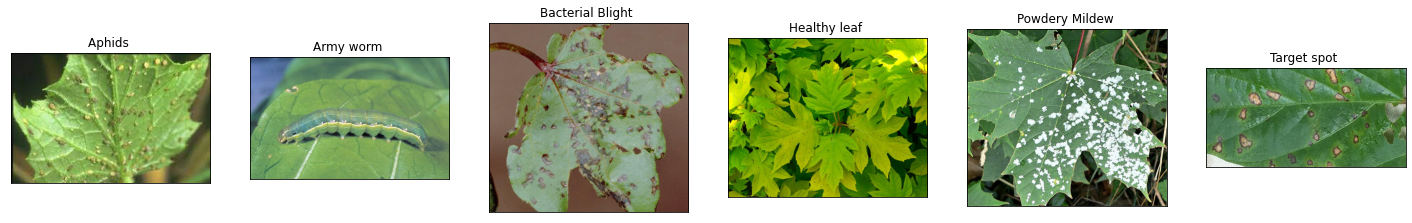

In [3]:
# generating a list with 1 random image from each class 
random_images = []
for i in enumerate(CLASSES):
    random_images.append(random.choice(glob.glob(os.path.join(FILE_PATH,CLASSES[i[0]]+'/*'))))
    
# showing each image in seperate column
n_cols = len(CLASSES)

# plot the images
plt.figure(figsize=(25, 10))
for c,r in zip(range(n_cols),random_images):
    ax = plt.subplot(1, n_cols, c + 1)
    title = r.split('disease\\')[1]
    title = title.split('edited')[0]
    title = title.split('Edited')[0]
    ax.title.set_text(title)
    image = cv2.imread(r)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
plt.show()


In [4]:
#data pipeline
AUTOTUNE = tf.data.experimental.AUTOTUNE

# configure training dataset
ds_train = image_data.prefetch(buffer_size=AUTOTUNE)

In [5]:
# data augmentation
'''
Since the dataset is small, as a good practice we'll introduce sample diversity by applying random transformations to the training images.
Here we're applying horizontal flip , rotation, contrast & zoom.
'''
# data_augmentation = keras.Sequential([
#   layers.RandomFlip('horizontal')
#   ,layers.RandomRotation(0.2)
#   ,layers.RandomContrast(0.2)
#   ,layers.RandomZoom(0.5,0.2)
# ])

# data_augmentation = tf.keras.layers.experimental.preprocessing.RandomFlip(
#     mode="horizontal_and_vertical", seed=None
# )

data_augmentation = keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip(
    mode="horizontal_and_vertical", seed=None
)
    ,tf.keras.layers.experimental.preprocessing.RandomRotation(
    factor=(-0.2, 0.3),
    fill_mode="reflect",
    interpolation="bilinear",
    seed=None,
)
    ,tf.keras.layers.experimental.preprocessing.RandomContrast(0.2, seed=None
)
    ,tf.keras.layers.experimental.preprocessing.RandomZoom(
    height_factor=(0.2, 0.3),
    width_factor=None,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=None
)
])

In [6]:
# rescale pixel values
preprocess_input = keras.applications.mobilenet_v2.preprocess_input
# rescale = layers.Rescaling(1./127.5, offset=-1)

In [7]:
# create base model - MobileNet V2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False,weights='imagenet')

In [8]:
# model's feature extractor shape conversion
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(f"{IMG_SHAPE} converted to {feature_batch.shape}")

(160, 160, 3) converted to (32, 5, 5, 1280)


In [9]:
# feature extraction
base_model.trainable = False

In [10]:
# classification head
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(f"Feature Batch Shape: {feature_batch_average.shape} ")

# prediction layer
prediction_layer =  layers.Dense(len(CLASSES),activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(f"Prediction Batch Shape: {prediction_batch.shape}")

Feature Batch Shape: (32, 1280) 
Prediction Batch Shape: (32, 6)


In [11]:
# build model
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
# model summary
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                

In [13]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
# training the model
epochs = 50
earlyStopping = keras.callbacks.EarlyStopping(monitor='loss',patience=3,verbose=0)
hist = model.fit(ds_train
          , epochs = epochs
          , batch_size=BATCH_SIZE
          ,shuffle=True
          ,verbose=0
          ,callbacks=[TqdmCallback(verbose=0),earlyStopping])

In [15]:
acc = '{:.2%}'.format(hist.history['accuracy'][-1])
print(f"Our model has achieved an accuracy of  {acc} in {len(hist.epoch)} epoch(s)")

Our model has achieved an accuracy of  87.34% in 48 epoch(s)


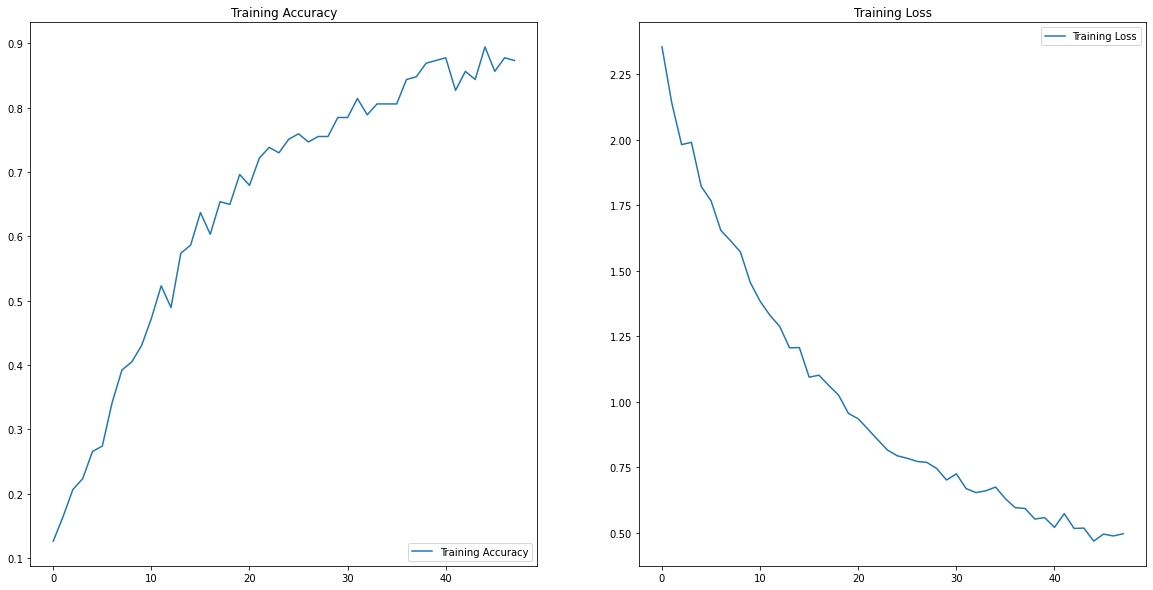

In [16]:
# plotting training accuracy & loss.
acc = hist.history['accuracy']
loss = hist.history['loss']
epochs_range = range(len(hist.epoch))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [17]:
model.save_weights("CottonPlantDiseaseClassifier.h5")

In [18]:
# fine tuning

base_model.trainable = True

# check number of layers in base model
print("Number of layers in the base model: ", len(base_model.layers))

# fine tuning top layers
fine_tune_at = 100

# freeze layers before the *fine_tune_at* layer
for l in base_model.layers[:fine_tune_at]:
    l.trainable = False

Number of layers in the base model:  155


In [19]:
# re-compile the model

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# model summary
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                

In [20]:
# re-training the model
hist_finetune = model.fit(ds_train
          , epochs = epochs
          , batch_size=BATCH_SIZE
          ,shuffle=True
          ,verbose=0
          ,callbacks=[TqdmCallback(verbose=0),earlyStopping])

In [21]:
acc_finetuned = '{:.2%}'.format(hist_finetune.history['accuracy'][-1])
print(f"After finetuning our model has achieved an accuracy of  {acc_finetuned} in {len(hist_finetune.epoch)} epoch(s)")

After finetuning our model has achieved an accuracy of  100.00% in 23 epoch(s)


In [22]:
# saving the model
model.save_weights("CottonPlantDiseaseClassifier_finetuned.h5")

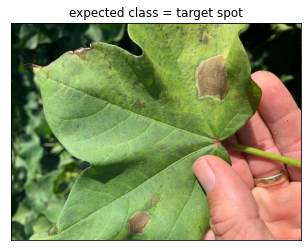

In [27]:
# get an image for predictions
'''
since there are no test/validation images, I'll be loading a completely unseen image from Google and see what the model has to predict.
the image is of class = target spot (expected)
'''
img_url = 'https://site.extension.uga.edu/bullochag/files/2022/08/image-1.png'   
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

# saving the image to output as jpg
img_data = requests.get(img_url).content
with open('unseenImage.jpg', 'wb') as handler:
    handler.write(img_data)

# plot the image
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('expected class = target spot')
plt.show()


In [31]:
# pre-processing the unseen image
image_path = './unseenImage.jpg'
unseen_img = keras.preprocessing.image.load_img(image_path,target_size=(IMG_SIZE, IMG_SIZE))
input_arr = tf.keras.preprocessing.image.img_to_array(unseen_img)
# convert single image to a batch
input_arr = np.array([input_arr])  
input_arr = input_arr.astype('float32') / 255. 

In [32]:
# making prediction
pred = model.predict(input_arr)
# predicting class
pred_class = np.argmax(pred, axis=1)
# predicting class name
image_data.class_names.reverse()
for c in enumerate(image_data.class_names):
    if c[0] == pred_class[0]:
        print(f"Predicted Class Name: {c[1].split('Edited')[0].split('edited')[0]}")
        pred_class_name = c[1].split('Edited')[0].split('edited')[0]


Predicted Class Name: Healthy leaf 


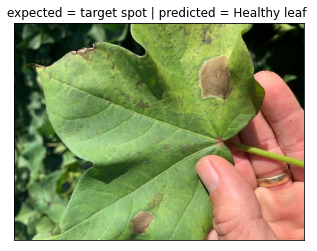

In [33]:
# plot the image
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('expected = target spot | predicted = '+pred_class_name.split('Edited')[0].split('edited')[0])

plt.show()